In [12]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import fAux
import mc_permutation
import detrendPrice 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, RocCurveDisplay, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, 
)
from sklearn.utils.class_weight import compute_class_weight


from xgboost import XGBClassifier, plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr

import ta
from ta.trend import EMAIndicator 
global global_returns
global global_labels

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols)



In [13]:
spy = pd.read_csv('data/spy.csv', index_col='date', parse_dates=True)
nvda = pd.read_csv('data/nvda.csv', index_col='date', parse_dates=True)
nvda.head()

,close,high,low,open,volume,ticker
date,,,,,,
1999-01-22,0.037609,0.044772,0.035579,0.040116,2714688000,nvda
1999-01-25,0.041549,0.042026,0.037609,0.040594,510480000,nvda
1999-01-26,0.038325,0.042862,0.037728,0.042026,343200000,nvda
1999-01-27,0.038206,0.039400,0.036295,0.038444,244368000,nvda
1999-01-28,0.038086,0.038444,0.037848,0.038206,227520000,nvda


In [ ]:
# model for longing
# binary target: 1 if price reverts up (above the threshold e.g. gain over 2%) wihtin the next five trading days, 0 otherwise
def create_target_long(df, threshold=0.02, lookahead=5):
    """
    Label as 1 if max return over the next 'lookahead' days is >= threshold.
    Else, label as 0.
    """
    df = df.copy()
    future_max = df['close'].shift(-1).rolling(window=lookahead).max()
    future_return = (future_max - df['close']) / df['close']
    df['target_long'] = (future_return >= threshold).astype(int)
    return df

def feature_engineering(df):
    df = df.copy()
    df['sma30'] = df['close'].rolling(30).mean()
    df['sma10'] = df['close'].rolling(10).mean()
    df['sma_diff'] = df['sma10'] - df['sma30']
    df['sma_slope'] = df['sma10'].diff()
    df['std30'] = df['close'].rolling(30).std()
    df['bollinger_upper'] = df['sma30'] + 2 * df['std30']
    df['bollinger_lower'] = df['sma30'] - 2 * df['std30']
    df['percent_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])
    df['bollinger_z'] = (df['close'] - df['sma30']) / df['std30']
    df['rsi14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()    
    df['prod_bollingerz_rsi'] = df['percent_b'] * df['rsi14']
    # Add more features as needed
    df.dropna(inplace=True)
    return df

def feature_engineering_2(df):
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    df['rolling_volatility14'] = df['daily_return'].rolling(window=30).std()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()
    spy_ret5 = spy['close'].pct_change(periods=5).fillna(0)
    df = df.merge(spy_ret5.rename('spy_ret5'), left_index=True, right_index=True, how='left')
    df.dropna(inplace=True)
    return df

def plot_model_metrics(y_true, y_proba, model_name):
    y_pred = (y_proba >= 0.5).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f'{model_name} - Confusion Matrix')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_disp.plot(ax=axes[1])
    axes[1].set_title(f'{model_name} - ROC Curve (AUC = {roc_auc:.2f})')

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_disp.plot(ax=axes[2])
    axes[2].set_title(f'{model_name} - Precision-Recall Curve')

    plt.tight_layout()
    plt.show()


def xgb_with_metrics(X, y, features, target='target_long', predict_proba_threshold=0.5):
    tscv = TimeSeriesSplit(n_splits=5)
    drop_cols = [col for col in X.columns if col not in features]
    pipeline = Pipeline([
        ('drop_features', FeatureDropper(drop_cols=drop_cols)),
        ('xgb', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ])

    
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= predict_proba_threshold).astype(int)

        print(f'Fold {i+1} - XGBoost:\n{classification_report(y_test, y_pred)}')

        if i == 0:
            print('Fold 1 visualized below')
            plot_model_metrics(y_test, y_proba, "XGBoost")

    return pipeline



def entry_exit(df):
    trades = []
    i = 0
    n = len(df)

    while i < n - 5:  # we need at least 5 days ahead
        if df['model_signal'].iloc[i] == 1:
            entry_date = df.index[i]
            entry_price = df['close'].iloc[i]
            exit_price = None
            exit_date = None
            holding = None

            for j in range(1, 6):  # check up to 5 days ahead
                if i + j >= n:
                    break

                next_price = df['close'].iloc[i + j]
                ret = (next_price - entry_price) / entry_price

                # Exit Conditions
                if ret >= 0.02:  # profit target
                    exit_price = next_price
                    exit_date = df.index[i + j]
                    holding = j
                    break
                elif ret <= -0.02:  # stop loss
                    exit_price = next_price
                    exit_date = df.index[i + j]
                    holding = j
                    break
                elif df['close'].iloc[i + j] >= df['sma30'].iloc[i + j]:  # revert to SMA30
                    exit_price = next_price
                    exit_date = df.index[i + j]
                    holding = j
                    break

            if exit_price is None:
                # Max holding (5th day)
                exit_price = df['close'].iloc[i + 5]
                exit_date = df.index[i + 5]
                holding = 5

            trade_return = (exit_price - entry_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'return': trade_return,
                'holding_days': holding
            })

            i = i + holding  # skip to the day after exit
        else:
            i += 1

    return trades


In [15]:
nvda_v1 = nvda.copy()
nvda_v1 = create_target_long(nvda_v1, threshold=0.02, lookahead=5)
nvda_v1 = feature_engineering(nvda_v1)
print(nvda_v1.shape)
nvda_v1.head()

(6630, 18)


,close,high,low,open,volume,ticker,target_long,sma30,sma10,sma_diff,sma_slope,std30,bollinger_upper,bollinger_lower,percent_b,bollinger_z,rsi14,prod_bollingerz_rsi
date,,,,,,,,,,,,,,,,,,
1999-03-05,0.040235,0.040354,0.038444,0.038444,78768000,nvda,1,0.038858,0.041453,0.002595,0.000036,0.002735,0.044328,0.033389,0.625865,0.503459,52.036081,32.567553
1999-03-08,0.040832,0.042026,0.038444,0.039161,75888000,nvda,1,0.038966,0.041525,0.002559,0.000072,0.002747,0.044460,0.033472,0.669837,0.679349,53.636065,35.927437
1999-03-09,0.042146,0.042743,0.040713,0.040713,143184000,nvda,0,0.038986,0.041537,0.002551,0.000012,0.002769,0.044523,0.033449,0.785379,1.141517,57.033799,44.793166
1999-03-10,0.041429,0.042743,0.040832,0.042743,235344000,nvda,0,0.039089,0.041143,0.002054,-0.000394,0.002801,0.044691,0.033488,0.708852,0.835407,54.678888,38.759230
1999-03-11,0.039638,0.041429,0.039638,0.040713,54288000,nvda,1,0.039137,0.040713,0.001576,-0.000430,0.002797,0.044732,0.033542,0.544799,0.179196,49.213726,26.811594


In [16]:
# baseline model
feats = [
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14'
]
X = nvda_v1[feats]
y = nvda_v1['target_long']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

tscv = TimeSeriesSplit(n_splits=5)

# check class balance
print(y_train.value_counts(normalize=True))

# models see below
# 1. Logistic Regression with time series cross-validation
# 2. Random Forest with time series cross-validation
# 3. XGBoost with time series cross-validation  
# 4. (LSTM not implemented since time lagging features are not created yet)


target_long
1    0.526207
0    0.473793
Name: proportion, dtype: float64


Fold 1 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.33      0.46       405
           1       0.62      0.92      0.74       479

    accuracy                           0.65       884
   macro avg       0.69      0.62      0.60       884
weighted avg       0.69      0.65      0.61       884

Fold 1 visualized below


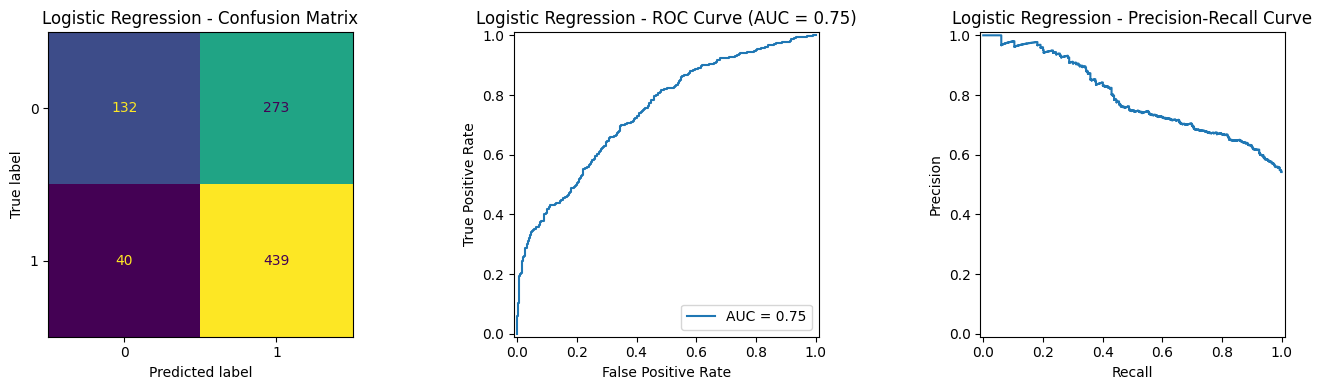

Fold 2 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47       349
           1       0.68      0.88      0.77       535

    accuracy                           0.68       884
   macro avg       0.67      0.62      0.62       884
weighted avg       0.67      0.68      0.65       884

Fold 3 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.35      0.48       406
           1       0.62      0.90      0.74       478

    accuracy                           0.65       884
   macro avg       0.69      0.63      0.61       884
weighted avg       0.68      0.65      0.62       884

Fold 4 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.49      0.63       619
           1       0.42      0.86      0.56       265

    accuracy                           0.60       884
   macro avg       0.65      0.67     

In [17]:
# 1. logistic regression with time series cross-validation

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    logistic_pipeline.fit(X_train, y_train)
    y_pred = logistic_pipeline.predict(X_test)
    print(f'Fold {i+1} - Logistic Regression:\n{classification_report(y_test, y_pred)}')
    
    if i == 0:
        print('Fold 1 visualized below')
        y_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
        plot_model_metrics(y_test, y_proba, "Logistic Regression")


### some notes for the metrics:
- task: enter high quality trades (even if its fewer)
- Precision: “When the model says BUY, how often is it right?”
- Recall: “Of all the good trade opportunities, how many did I catch?”
- We don't need to care about accuracy (e.g., it can be accurate but useless if it's mostly right about true neg (non-trade), like we won't enter the trade anyways)
- so overall, precision > recall > accuracy here

Fold 1 - Random Forest:
              precision    recall  f1-score   support

           0       0.62      0.20      0.31       276
           1       0.66      0.93      0.77       460

    accuracy                           0.65       736
   macro avg       0.64      0.56      0.54       736
weighted avg       0.65      0.65      0.60       736

Fold 1 visualized below


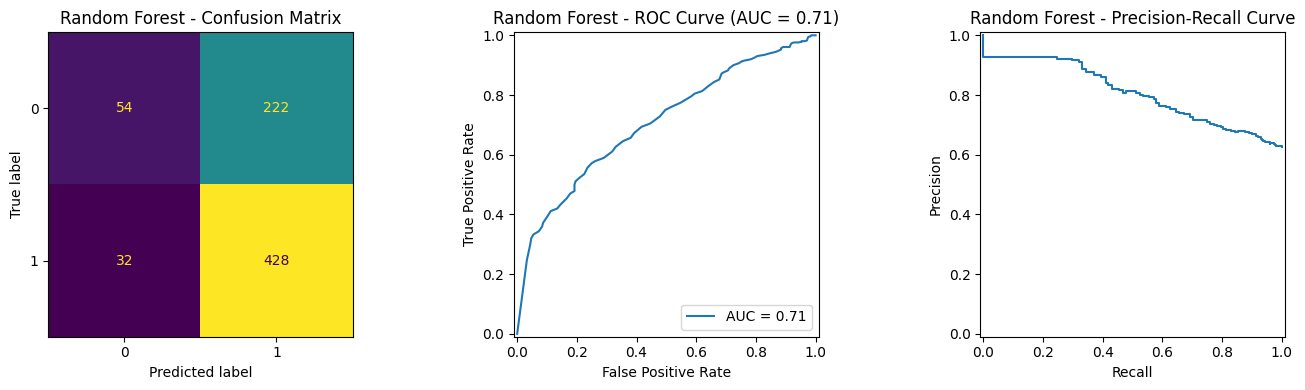

Fold 2 - Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.41      0.53       375
           1       0.58      0.86      0.70       361

    accuracy                           0.63       736
   macro avg       0.67      0.63      0.61       736
weighted avg       0.67      0.63      0.61       736

Fold 3 - Random Forest:
              precision    recall  f1-score   support

           0       0.59      0.47      0.52       270
           1       0.73      0.82      0.77       466

    accuracy                           0.69       736
   macro avg       0.66      0.64      0.65       736
weighted avg       0.68      0.69      0.68       736

Fold 4 - Random Forest:
              precision    recall  f1-score   support

           0       0.72      0.51      0.60       390
           1       0.58      0.78      0.67       346

    accuracy                           0.64       736
   macro avg       0.65      0.64      0.63       736
we

In [18]:
# 2. random forest with time series cross-validation
rf = RandomForestClassifier(n_estimators=100, random_state=42)

for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f'Fold {i+1} - Random Forest:\n{classification_report(y_test, y_pred)}')

    if i == 0:
        print('Fold 1 visualized below')
        y_proba = rf.predict_proba(X_test)[:, 1]
        plot_model_metrics(y_test, y_proba, "Random Forest")


Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.60      0.25      0.35       405
           1       0.57      0.86      0.69       479

    accuracy                           0.58       884
   macro avg       0.59      0.55      0.52       884
weighted avg       0.59      0.58      0.53       884

Fold 1 visualized below


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


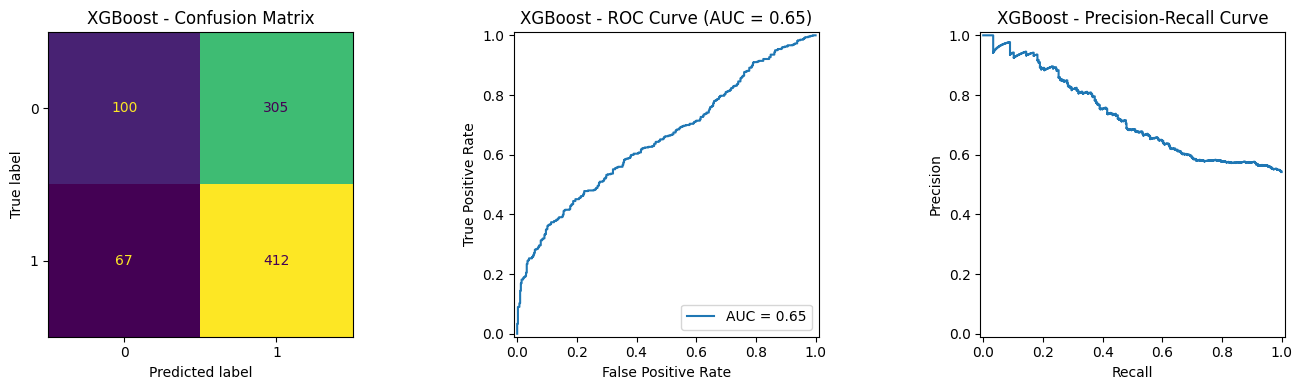

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.60      0.34      0.44       349
           1       0.67      0.85      0.75       535

    accuracy                           0.65       884
   macro avg       0.63      0.60      0.59       884
weighted avg       0.64      0.65      0.63       884

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.65      0.44      0.53       406
           1       0.63      0.80      0.70       478

    accuracy                           0.63       884
   macro avg       0.64      0.62      0.61       884
weighted avg       0.64      0.63      0.62       884



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.52      0.65       619
           1       0.42      0.83      0.56       265

    accuracy                           0.61       884
   macro avg       0.65      0.67      0.61       884
weighted avg       0.74      0.61      0.63       884

Fold 5 - XGBoost:
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       492
           1       0.59      0.75      0.66       392

    accuracy                           0.66       884
   macro avg       0.67      0.67      0.66       884
weighted avg       0.68      0.66      0.66       884



,steps,"[('drop_features', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,drop_cols,"['close', 'high', ...]"
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [19]:
# 3. XGBoost with time series cross-validation
X = nvda_v1.drop(columns=['target_long'])
y = nvda_v1['target_long']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
xgb_with_metrics(X_train, y_train, features=feats)

In [20]:
nvda_v1.columns

Index(['close', 'high', 'low', 'open', 'volume', 'ticker', 'target_long',
       'sma30', 'sma10', 'sma_diff', 'sma_slope', 'std30', 'bollinger_upper',
       'bollinger_lower', 'percent_b', 'bollinger_z', 'rsi14',
       'prod_bollingerz_rsi'],
      dtype='object')

Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.61      0.19      0.29       405
           1       0.57      0.90      0.70       479

    accuracy                           0.57       884
   macro avg       0.59      0.54      0.49       884
weighted avg       0.59      0.57      0.51       884

Fold 1 visualized below


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


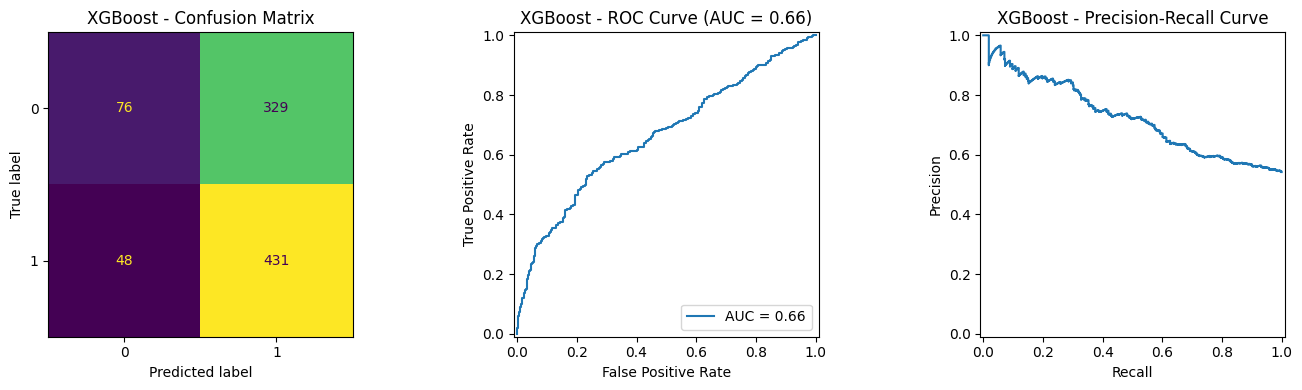

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.57      0.31      0.40       349
           1       0.65      0.85      0.74       535

    accuracy                           0.63       884
   macro avg       0.61      0.58      0.57       884
weighted avg       0.62      0.63      0.60       884

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.65      0.43      0.51       406
           1       0.62      0.80      0.70       478

    accuracy                           0.63       884
   macro avg       0.64      0.61      0.61       884
weighted avg       0.63      0.63      0.62       884



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       619
           1       0.46      0.77      0.58       265

    accuracy                           0.66       884
   macro avg       0.66      0.69      0.65       884
weighted avg       0.74      0.66      0.67       884

Fold 5 - XGBoost:
              precision    recall  f1-score   support

           0       0.76      0.49      0.60       492
           1       0.56      0.80      0.66       392

    accuracy                           0.63       884
   macro avg       0.66      0.65      0.63       884
weighted avg       0.67      0.63      0.63       884



,steps,"[('drop_features', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,drop_cols,"['close', 'high', ...]"
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [21]:
# model 2: try using more features
feats2 = [
    'volume',               
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14',
    'prod_bollingerz_rsi'
]

X2 = nvda_v1.drop(columns=['target_long'])
y2 = nvda_v1['target_long']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, shuffle=False)
xgb_with_metrics(X_train2, y_train2, features=feats2)

(5280, 21)
Fold 1 - XGBoost:
              precision    recall  f1-score   support

           0       0.64      0.28      0.39       409
           1       0.58      0.86      0.69       471

    accuracy                           0.59       880
   macro avg       0.61      0.57      0.54       880
weighted avg       0.61      0.59      0.55       880

Fold 1 visualized below


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


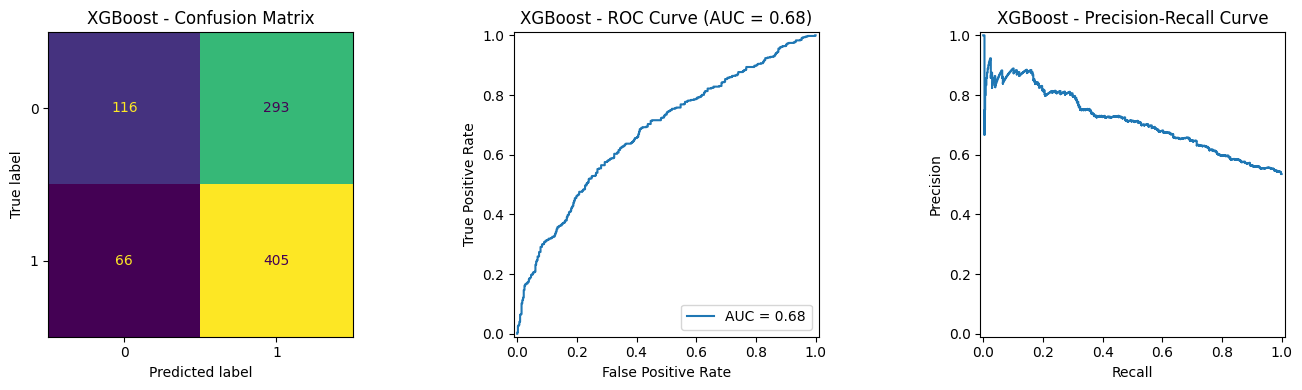

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - XGBoost:
              precision    recall  f1-score   support

           0       0.66      0.42      0.51       349
           1       0.69      0.86      0.77       531

    accuracy                           0.68       880
   macro avg       0.68      0.64      0.64       880
weighted avg       0.68      0.68      0.67       880

Fold 3 - XGBoost:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       405
           1       0.68      0.80      0.73       475

    accuracy                           0.69       880
   macro avg       0.69      0.68      0.68       880
weighted avg       0.69      0.69      0.68       880



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 - XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       619
           1       0.58      0.66      0.62       261

    accuracy                           0.76       880
   macro avg       0.72      0.73      0.72       880
weighted avg       0.77      0.76      0.76       880

Fold 5 - XGBoost:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       485
           1       0.64      0.73      0.68       395

    accuracy                           0.70       880
   macro avg       0.70      0.70      0.70       880
weighted avg       0.70      0.70      0.70       880



In [22]:
# model 3: use advanced features for xgb
nvda_v2 = feature_engineering_2(nvda_v1.copy())
# print(nvda_v2.shape)
# print(nvda_v2.head())

feats3 = [
    'volume',               
    'sma_diff',
    'sma_slope',
    'bollinger_z',
    'percent_b',
    'rsi14',
    'prod_bollingerz_rsi',
    'rolling_volatility14',
    'atr',
    'spy_ret5'
]

X3 = nvda_v2.drop(columns=['target_long'])
y3 = nvda_v2['target_long']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42, shuffle=False)
print(X_train3.shape)
pipe = xgb_with_metrics(X_train3, y_train3, features=feats3)

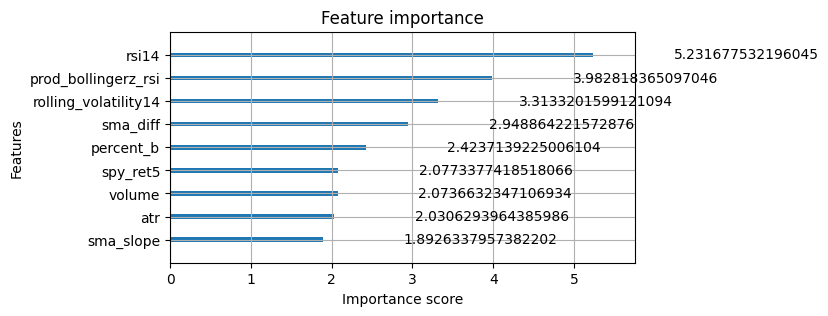

In [23]:
# check feature importance
fig, ax = plt.subplots(figsize=(6,3)) 
plot_importance(pipe.named_steps['xgb'], importance_type='gain', max_num_features=20, ax=ax)
plt.show()


# Backtesting

In [24]:
testing = X_test3.copy()
testing['proba'] = pipe.predict_proba(X_test3)[:, 1]
testing['model_signal'] = (testing['proba'] >= 0.7).astype(int)
# print(testing.sample(10).sort_index())
trades = entry_exit(testing)
trades_df = pd.DataFrame(trades).merge(
    testing.reset_index()[['date','rolling_volatility14']],
    left_on='entry_date',
    right_on='date',
    how='left'
)
trades_df.head()

,entry_date,exit_date,entry_price,exit_price,return,holding_days,date,rolling_volatility14
0,2020-04-13,2020-04-14,6.721019,7.072202,0.052251,1,2020-04-13,0.075021
1,2020-04-14,2020-04-15,7.072202,6.994741,-0.010953,1,2020-04-14,0.075478
2,2020-04-15,2020-04-16,6.994741,7.339946,0.049352,1,2020-04-15,0.075121
3,2020-04-16,2020-04-17,7.339946,7.280668,-0.008076,1,2020-04-16,0.074593
4,2020-04-20,2020-04-21,7.149411,6.712551,-0.061104,1,2020-04-20,0.074075


In [33]:
trades_df.columns

Index(['entry_date', 'exit_date', 'entry_price', 'exit_price', 'return',
       'holding_days', 'date', 'rolling_volatility14', 'equity', 'size', 'pnl',
       'capped_return', 'cumulative_return', 'running_max', 'drawdown'],
      dtype='object')

In [25]:
win_rate = (trades_df['return'] > 0).mean()
avg_win = trades_df[trades_df['return'] > 0]['return'].mean()
avg_loss = trades_df[trades_df['return'] <= 0]['return'].mean()
expectancy = win_rate * avg_win + (1 - win_rate) * avg_loss
max_drawdown = (trades_df['return'].cumsum().cummax() - trades_df['return'].cumsum()).max()
sharpe = trades_df['return'].mean() / trades_df['return'].std()
print(f'Win Rate: {win_rate:.2f}')
print(f'Average Win: {avg_win:.2f}')
print(f'Average Loss: {avg_loss:.2f}')
print(f'Expectancy: {expectancy:.2f}')
print(f'Max Drawdown: {max_drawdown:.2f}')
print(f'Sharpe Ratio: {sharpe:.2f}')

Win Rate: 0.54
Average Win: 0.04
Average Loss: -0.03
Expectancy: 0.00
Max Drawdown: 0.59
Sharpe Ratio: 0.10


<Axes: title={'center': 'Equity Curve'}>

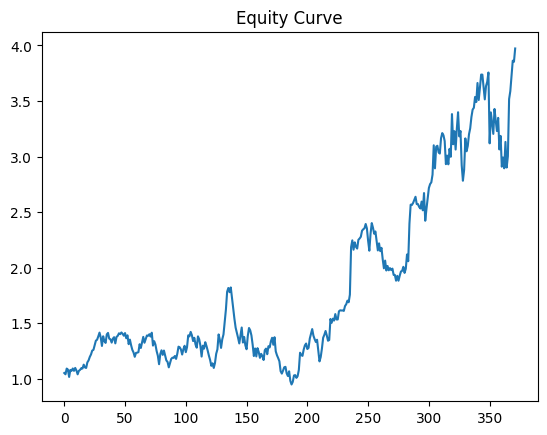

In [26]:
trades_df['equity'] = (1 + trades_df['return']).cumprod()
trades_df['equity'].plot(title='Equity Curve')


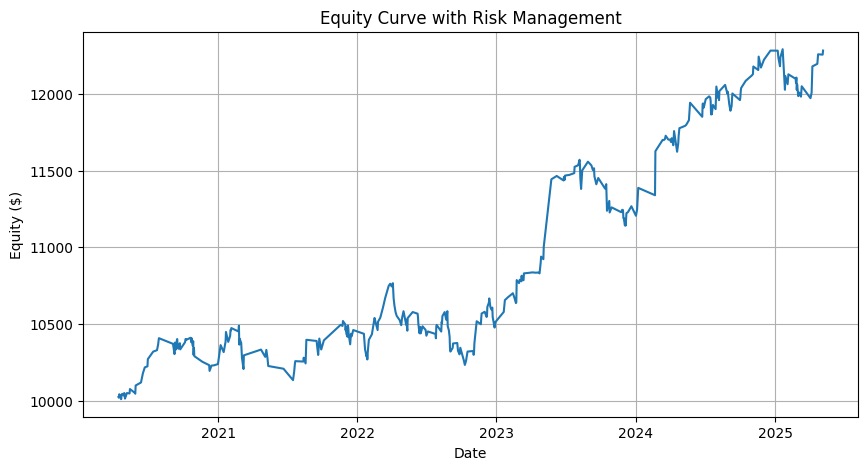

Total trades: 372
first trade day: 2020-04-13 00:00:00, last trade day: 2025-05-07 00:00:00


In [ ]:
initial_capital = 10000
position_size = 1000  
# trades_df['pnl'] = trades_df['return'] * position_size

# add dynamic sizing
risk_fraction = 0.1
vol_normalizer = trades_df['rolling_volatility14'].median()
equity_history = []
current_equity = initial_capital

# Ensure trades are in chronological order
trades_df = trades_df.sort_values('entry_date').reset_index(drop=True)

# Loop to calculate size and equity dynamically
for i, row in trades_df.iterrows():
    # Allocate position size based on current equity and volatility
    dollar_position = current_equity * risk_fraction * (vol_normalizer / row['rolling_volatility14'])
    size = dollar_position / row['entry_price']
    pnl = row['return'] * size * row['entry_price']
    current_equity += pnl  # update current equity after trade closes
    
    # Store results
    equity_history.append({
        'size': size,
        'pnl': pnl,
        'equity': current_equity
    })

# Convert to DataFrame and merge back
equity_df = pd.DataFrame(equity_history)
trades_df[['size', 'pnl', 'equity']] = equity_df[['size', 'pnl', 'equity']]

plt.figure(figsize=(10, 5))
plt.plot(trades_df['exit_date'], trades_df['equity'])
plt.title("Equity Curve with Risk Management")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.grid()
plt.show()
print(f'Total trades: {len(trades_df)}')
print(f'first trade day: {trades_df["entry_date"].min()}, last trade day: {trades_df["exit_date"].max()}')


In [35]:
trades_df[['date','size']]

,date,size
0,2020-04-13,68.783050
1,2020-04-14,65.129169
2,2020-04-15,66.129898
3,2020-04-16,63.610569
4,2020-04-20,65.737561
...,...,...
367,2025-04-21,8.464354
368,2025-04-22,8.404147
369,2025-04-23,8.045611
370,2025-05-05,7.472480


In [29]:
stop_loss = -0.03  # -3% stop loss
take_profit = 0.05  # +5% take profit

# Clamp returns
trades_df['capped_return'] = trades_df['return'].clip(lower=stop_loss, upper=take_profit)
trades_df['pnl'] = trades_df['capped_return'] * position_size
trades_df['equity'] = trades_df['pnl'].cumsum() + initial_capital

win_rate = (trades_df['capped_return'] > 0).mean()
avg_win = trades_df[trades_df['capped_return'] > 0]['capped_return'].mean()
avg_loss = trades_df[trades_df['capped_return'] <= 0]['capped_return'].mean()
expectancy = win_rate * avg_win + (1 - win_rate) * avg_loss
sharpe = trades_df['capped_return'].mean() / trades_df['capped_return'].std()

trades_df['cumulative_return'] = trades_df['pnl'].cumsum()
trades_df['running_max'] = trades_df['cumulative_return'].cummax()
trades_df['drawdown'] = trades_df['running_max'] - trades_df['cumulative_return']
max_drawdown = trades_df['drawdown'].max()
peak_equity = trades_df['running_max'].max()

print(f"Win Rate: {win_rate:.2f}")
print(f"Expectancy per trade: {expectancy:.4f}")
print(f"Sharpe Ratio (raw): {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}; {(max_drawdown / peak_equity) * 100:.2f}%")

Win Rate: 0.54
Expectancy per trade: 0.0055
Sharpe Ratio (raw): 0.19
Max Drawdown: 210.00; 10.27%
